Extension of the 1D problem solutions to the mass spring damper IVP. 


The difference with the diffusion problem of the first notebook, is that the boundary conditions are not dirichlet boundary conditions. Rather, it is an IVP so the initial value and derivative is prescribed.

The ansatz is still 
$$u=G(x)+D(x)*y^L$$
but to satisfy the IVP constraint, $G(0), G'(0)=y(0), y'(0)$ and $D, \frac{dD}{dx}=0$


This still follows Berg & Nystrom's approach, but their examples only covered Dirichlet boundary conditions. The Neumann BC's are the new thing here. 


Convergence issues seem to happen when the maximum time covered comes close to the period of motion. The residual does not decrease anymore after a few iterations, and is not satisfactory. It is unclear why this happens. Possible reasons: optimization hitting local minimum, or issues relating to periodicity (i.e. the ansatz is not capable of deal


\begin{itemize}
\item Local minimum
\item Periodicity
\end{itemize}


In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad, jacobian
from autograd.misc.optimizers import adam, sgd

from reusable_functions import init_random_params, neural_net_predict

m=1.; c=0.; k=1.; max_time=7.;

#Parameters
nx = 150
dx = max_time / nx
x_space = np.linspace(0, max_time, nx)
batch_size=50;
layer_sizes = [1,10,10,1]
param_scale = 1
step_size=0.01; #for the optimizer
num_iterations=200;



G=lambda x:1. #to satisfy BCs
D=lambda x:np.square(x)/(1+np.square(x)) #distance function
#D=lambda x:np.square(x) #distance function
forcing_fn = lambda x: 0


dydx=grad(neural_net_predict,1)
dydx2=grad(dydx,1)
dGdx2=grad(grad(G))
dDdx=grad(D)
dDdx2=grad(grad(D))
#u=lambda x,y:G(x)+D(x)*y For some reason this approach doesn't work. Possibly autograd handling.
#dudx=grad(u, 0)
#dudx2=grad(dudx,0)

#multiple evaluations of y are inefficient. use get_dus for loss function. 
def u(params, x):
    y=neural_net_predict(params,x)
    return G(x)+D(x)*y

def dudx(params, x):
    y=neural_net_predict(params,x)
    return dDdx(x)*y+D(x)*dydx(params,x)
    
def dudx2(params, x):
    y=neural_net_predict(params,x) #todo: change to objective with val fn for efficiency
    return dGdx2(x)+dDdx2(x)*y+2*dDdx(x)*dydx(params, x)+D(x)*dydx2(params, x)

#Save on neural network evaluations. 
def get_dus(params,x):
    """Return u, dudx, dudx2"""
    y=neural_net_predict(params,x)
    dydx_val=dydx(params, x)
    dydx2_val=dydx2(params, x)
    return G(x)+D(x)*y, dDdx(x)*y+D(x)*dydx_val, dGdx2(x)+dDdx2(x)*y+2*dDdx(x)*dydx_val+D(x)*dydx2_val
            

In [2]:
def resid(params, x_batch):
    loss_sum = 0.
    for i, x in enumerate(x_batch):
        #y=neural_net_predict(params, x)[0]
        
        #resid=m*dudx2(x,y)+c*dudx(x,y)+k*u(x,y)-forcing_fn(x) for some reason this approach doesnt work. 
        #u_val=G(x)+D(x)*y
        #dudx2=dGdx2(x)+dDdx2(x)*y+2*dDdx(x)*dydx(params,x)+D(x)*dydx2(params,x)
        u_val, dudx_val, dudx2_val=get_dus(params,x)
        
        resid=m*dudx2_val+c*dudx_val+k*u_val-forcing_fn(x)
        loss_sum=loss_sum+np.square(resid)
    return loss_sum/len(x_batch)
    
def loss_function(params,iter):
    
    x_batch=np.random.choice(x_space,size=batch_size) #random choice of points
    return resid(params, x_batch)
        

def accuracy(params):
    return resid(params, x_space)

In [3]:
print("     Iteration     |    Loss fn over x_space ")
def print_perf(params, iter, gradient):
    if iter % 100 == 0:
        acc = accuracy(params)[0]
        print("{:15}|{:20}".format(iter//1., str(acc[0])))
        


init_params = init_random_params(param_scale, layer_sizes)

objective_grad = grad(loss_function)

optimized_params = adam(objective_grad, init_params, step_size=step_size,
                       num_iters=num_iterations, callback=print_perf)

     Iteration     |    Loss fn over x_space 


/home/vassili/anaconda3/envs/thesis/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/vassili/anaconda3/envs/thesis/lib/python3.7/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


            0.0|1.7404204222162674  
          100.0|0.06628899597578349 


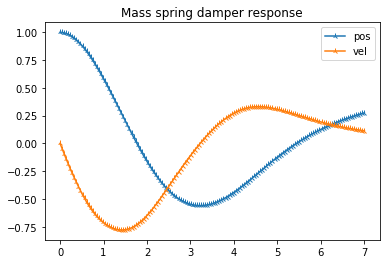

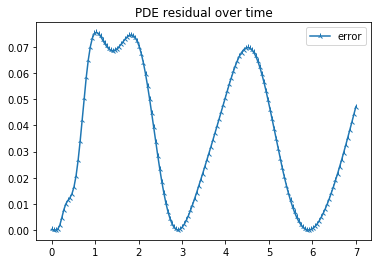

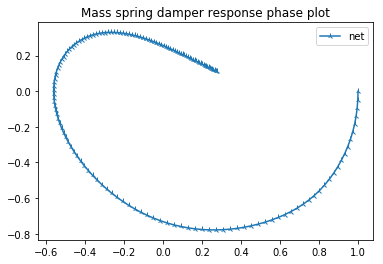

In [4]:
plt.figure(1)
plt.clf()
ax=plt.gca()
pos = np.zeros(nx)
vel = np.zeros(nx)

for i,x in enumerate(x_space):
    y=neural_net_predict(optimized_params, x)[0]
    pos[i]=u(optimized_params,x)
    vel[i]=dudx(optimized_params,x)
plttitle='Mass spring damper response'
plt.plot(x_space, pos, label='pos', marker='2')
plt.plot(x_space, vel, label='vel', marker='2')
plt.title(plttitle)
ax.legend()


plt.figure(2)
plt.clf()
ax=plt.gca()
err = np.zeros(nx)
for i,x in enumerate(x_space):
    err[i]=resid(optimized_params, np.array([x]))
plttitle='PDE residual over time'
plt.plot(x_space, err, label='error', marker='2')
plt.title(plttitle)
ax.legend()

plt.figure(3)
plt.clf()
ax=plt.gca()

plttitle='Mass spring damper response phase plot'
plt.plot(pos, vel, label='net', marker='2')
plt.title(plttitle)
ax.legend()

In [5]:
np.array([1])

array([1])